# GAIA to TESS

In [87]:
import lightkurve as lk
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle

import sys
sys.path
sys.path.append('./dave/diffimg/')
import tessprf as prf
from scipy import interpolate
from scipy import signal

In [96]:
def Get_TESS(RA,DEC,Size,Sector=None):
    c = SkyCoord(ra=float(RA)*u.degree, dec=float(DEC) *
                 u.degree, frame='icrs')
    
    tess = lk.search_tesscut(c,sector=Sector)
    tpf = tess.download(cutout_size=Size)
    
    return tpf

def Downsample(PSconv):
	"""
	Downsamples the PS image to the resolution of TESS.
	Inputs
    ------
    PSconv: array like
    	The PS image convolved with the TESS PSF
	Returns
	-------
	TESS_resolution: array like
		The PS image reduced to the TESS resolution
	"""
	PSpixel = 0.021 # arcseconds per pixel 
	TESSpixel = 21 # arcseconds per pixel 
	Scale = 100#TESSpixel/PSpixel
	xnew = np.arange(PSconv.shape[1]/Scale)
	ynew = np.arange(PSconv.shape[0]/Scale)
	TESS_resolution = np.zeros((int(PSconv.shape[0]/Scale),int(PSconv.shape[1]/Scale)))
	for i in range(len(ynew)-1):
		ystart = int(i*Scale)
		yend = int(ystart + Scale)
		for j in range(len(xnew)-1):
			xstart = int(j*Scale)
			xend = int(xstart + Scale)
			TESS_resolution[i,j] = np.nansum(PSconv[ystart:yend,xstart:xend])
	return TESS_resolution

In [163]:
def Interp_PRF(Row,Col,Camera,CCD):
    pathToMatFile = './data/prf/'
    obj = prf.TessPrf(pathToMatFile)
    PRF = obj.getPrfAtColRow(Row, Col, 1,Camera,CCD)
    norm = np.nansum(PRF)
    x2 = np.arange(0,PRF.shape[1]-1,0.01)
    y2 = np.arange(0,PRF.shape[0]-1,0.01)

    x = np.arange(0,PRF.shape[1],1)
    y = np.arange(0,PRF.shape[0],1)
    X, Y = np.meshgrid(x,y)

    x=X.ravel()              #Flat input into 1d vector
    y=Y.ravel()

    z = PRF
    z = z.ravel()
    x = list(x[np.isfinite(z)])
    y = list(y[np.isfinite(z)])
    z = list(z[np.isfinite(z)])

    znew = interpolate.griddata((x, y), z, (x2[None,:], y2[:,None]), method='cubic')
    kernal = znew
    kernal = kernal * (norm/np.nansum(kernal))
    return kernal

def Gaia(tpf, magnitude_limit = 18):
    c1 = SkyCoord(tpf.ra, tpf.dec, frame='icrs', unit='deg')
    # Use pixel scale for query size
    pix_scale = 4.0  # arcseconds / pixel for Kepler, default
    if tpf.mission == 'TESS':
        pix_scale = 21.0
    # We are querying with a diameter as the radius, overfilling by 2x.
    from astroquery.vizier import Vizier
    Vizier.ROW_LIMIT = -1
    result = Vizier.query_region(c1, catalog=["I/345/gaia2"],
                                 radius=Angle(np.max(tpf.shape[1:]) * pix_scale, "arcsec"))
    no_targets_found_message = ValueError('Either no sources were found in the query region '
                                          'or Vizier is unavailable')
    too_few_found_message = ValueError('No sources found brighter than {:0.1f}'.format(magnitude_limit))
    if result is None:
        raise no_targets_found_message
    elif len(result) == 0:
        raise too_few_found_message
    result = result["I/345/gaia2"].to_pandas()
    
    result = result[result.Gmag < magnitude_limit]
    if len(result) == 0:
        raise no_targets_found_message
    radecs = np.vstack([result['RA_ICRS'], result['DE_ICRS']]).T
    coords = tpf.wcs.all_world2pix(radecs, 1) ## TODO, is origin supposed to be zero or one?
    Gmag = result['Gmag'].values
    #Jmag = result['Jmag']
    ind = (((coords[:,0] >= -0.5*tpf.shape[1]) & (coords[:,1] >= -0.5*tpf.shape[2])) & 
           ((coords[:,0] < 1.5*tpf.shape[1]) & (coords[:,1] < 1.5*tpf.shape[2])))
    coords = coords[ind]
    Gmag = Gmag[ind]
    #Jmag = Jmag[ind]
    return coords, Gmag

def TIC(tpf, magnitude_limit = 18):
    c1 = SkyCoord(tpf.ra, tpf.dec, frame='icrs', unit='deg')
    # Use pixel scale for query size
    pix_scale = 4.0  # arcseconds / pixel for Kepler, default
    if tpf.mission == 'TESS':
        pix_scale = 21.0
    # We are querying with a diameter as the radius, overfilling by 2x.
    from astroquery.vizier import Vizier
    Vizier.ROW_LIMIT = -1
    result = Vizier.query_region(c1, catalog=["TIC"],
                                 radius=Angle(np.max(tpf.shape[1:]) * pix_scale, "arcsec"))
    no_targets_found_message = ValueError('Either no sources were found in the query region '
                                          'or Vizier is unavailable')
    too_few_found_message = ValueError('No sources found brighter than {:0.1f}'.format(magnitude_limit))
    if result is None:
        raise no_targets_found_message
    elif len(result) == 0:
        raise too_few_found_message
    result = result["I/197A/tic"].to_pandas()
    
    result = result[result.Vmag < magnitude_limit]
    if len(result) == 0:
        raise no_targets_found_message
    radecs = np.vstack([result['RAJ2000'], result['DEJ2000']]).T
    coords = tpf.wcs.all_world2pix(radecs, 1) ## TODO, is origin supposed to be zero or one?
    Gmag = result['Vmag'].values
    #Jmag = result['Jmag']
    ind = (((coords[:,0] >= -0.5*tpf.shape[1]) & (coords[:,1] >= -0.5*tpf.shape[2])) & 
           ((coords[:,0] < 1.5*tpf.shape[1]) & (coords[:,1] < 1.5*tpf.shape[2])))
    coords = coords[ind]
    Gmag = Gmag[ind]
    #Jmag = Jmag[ind]
    return coords, Gmag

In [155]:
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = -1
c1 = SkyCoord(tpf.ra, tpf.dec, frame='icrs', unit='deg')
result = Vizier.query_region(c1, catalog=["TIC"],
                                 radius=Angle(np.max(tpf.shape[1:]) * 24, "arcsec"))

result = result["I/197A/tic"].to_pandas()

In [156]:
result

,TICID1,TICID2,RAJ2000,DEJ2000,ePos,e_Bmag,Bmag,e_Vmag,Vmag,Flag1
0,3611,1156,b'22 23 36.769',b'+47 04 02.38',23,NaN,NaN,0.40,11.4,0
1,3611,1182,b'22 24 06.759',b'+47 05 21.50',22,NaN,NaN,0.40,11.5,0
2,3611,1484,b'22 24 34.209',b'+46 54 59.59',22,NaN,NaN,0.40,11.4,0
3,3611,1532,b'22 24 37.500',b'+46 55 19.25',23,NaN,NaN,0.01,11.9,0
4,3611,1548,b'22 23 39.729',b'+46 59 28.79',33,NaN,NaN,0.40,11.1,0
5,3611,1669,b'22 24 01.319',b'+47 00 18.68',32,NaN,NaN,0.50,9.0,0
6,3611,2032,b'22 24 37.437',b'+46 57 55.68',23,NaN,NaN,0.01,12.1,0
7,3611,2148,b'22 24 27.839',b'+46 56 26.29',24,NaN,NaN,0.40,10.6,0


In [152]:
result

TableList with 1 tables:
	'0:I/197A/tic' with 10 column(s) and 1 row(s) 

In [171]:
tpf = Get_TESS(30.26933,24.50988,20)

In [164]:
TIC(tpf)

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

In [172]:
pos, gmag = Gaia(tpf)

<IPython.core.display.Javascript object>


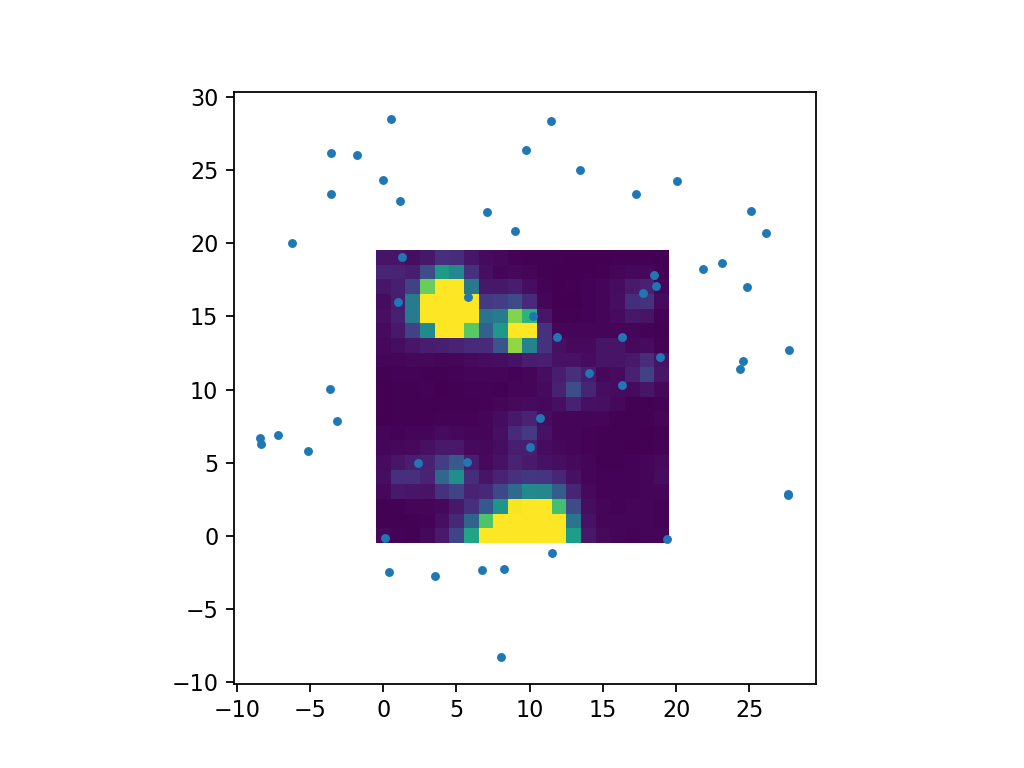

In [174]:
plt.figure()
plt.imshow(tpf.flux[100],origin='lower',vmax = 500)
plt.plot(pos[:,0],pos[:,1],'.')

In [142]:
def GAIA_scene(Ra,Dec,Size):
    tpf = Get_TESS(Ra,Dec,Size)
    pos, gmag = Gaia(tpf,magnitude_limit=16)
    Tmag = gmag - 0.5
    tcounts = 10**(-2/5*(Tmag - 20.44))
    sources = np.zeros((len(pos),tpf.shape[1],tpf.shape[2]))
    for i in range(len(pos)):
        template = np.zeros((2*tpf.shape[1]*100,2*tpf.shape[2]*100))
        kernal = Interp_PRF(pos[i,0] + tpf.row, pos[i,1] + tpf.column,tpf.camera,tpf.ccd) # check row and column are right
        #print(template.shape)
        offset1 = int(0.5 * tpf.shape[1] * 100)
        offset2 = int(0.5 * tpf.shape[2] * 100)
        template[int(pos[i,0]*100 + offset1),int(pos[i,1]*100+ offset2)] = tcounts[i]
        template = signal.fftconvolve(template, kernal, mode='same')
        template = template[offset1:int(3*offset1+1),offset2:int(3*offset2+1)]
        sources[i] = Downsample(template)
    return sources 

In [165]:
test = GAIA_scene(336,60,20)

/Users/ryanr/miniconda3/lib/python3.7/site-packages/lightkurve/search.py:202: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


In [114]:
from scipy.ndimage import  rotate
from astropy.visualization import (SqrtStretch, ImageNormalize)

In [177]:
tpf = Get_TESS(336,60,20)

/Users/ryanr/miniconda3/lib/python3.7/site-packages/lightkurve/search.py:202: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


<IPython.core.display.Javascript object>


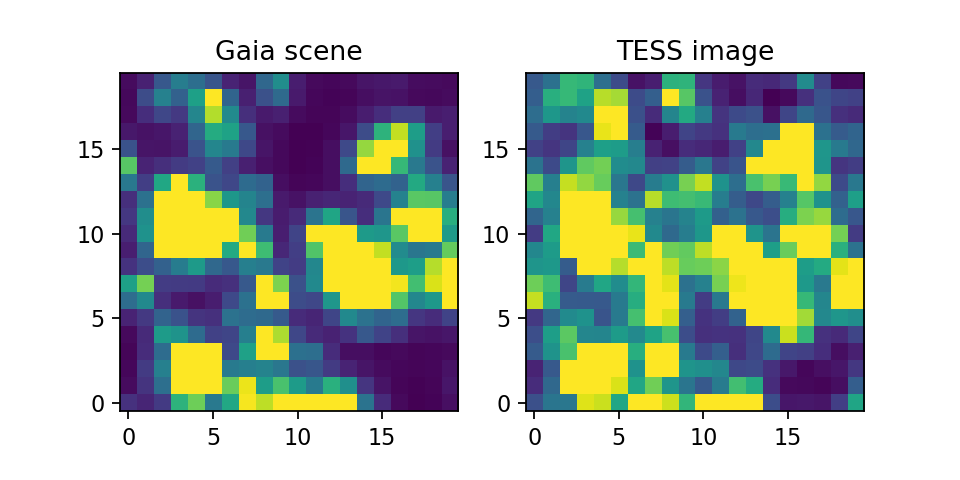

In [189]:
gaia = np.nansum(test,axis=0)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title('Gaia scene')
plt.imshow(rotate(np.flipud(gaia/np.nanmax(gaia)),-90),origin='lower',vmax = .05)
plt.subplot(1,2,2)
plt.title('TESS image')
plt.imshow(tpf.flux[100]/np.nanmax(tpf.flux[100]),origin='lower',vmax = .11)
plt.savefig('gaia_scene.png')

<IPython.core.display.Javascript object>


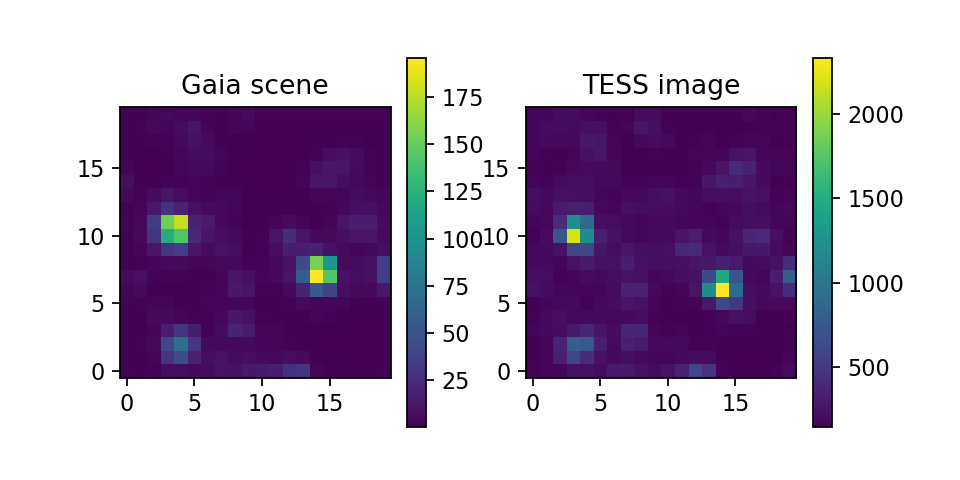

In [190]:
gaia = np.nansum(test,axis=0)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title('Gaia scene')
plt.imshow(rotate(np.flipud(gaia),-90),origin='lower')
plt.colorbar()
plt.subplot(1,2,2)
plt.title('TESS image')
plt.imshow(tpf.flux[0],origin='lower')
plt.colorbar()


#plt.savefig('gaia_scene.png')


In [192]:
tpf.shape

(1118, 20, 20)

In [196]:
allsum = np.nansum(tpf.flux,axis=(1,2))

In [202]:
ind = np.percentile(allsum,5) >  allsum  

<IPython.core.display.Javascript object>


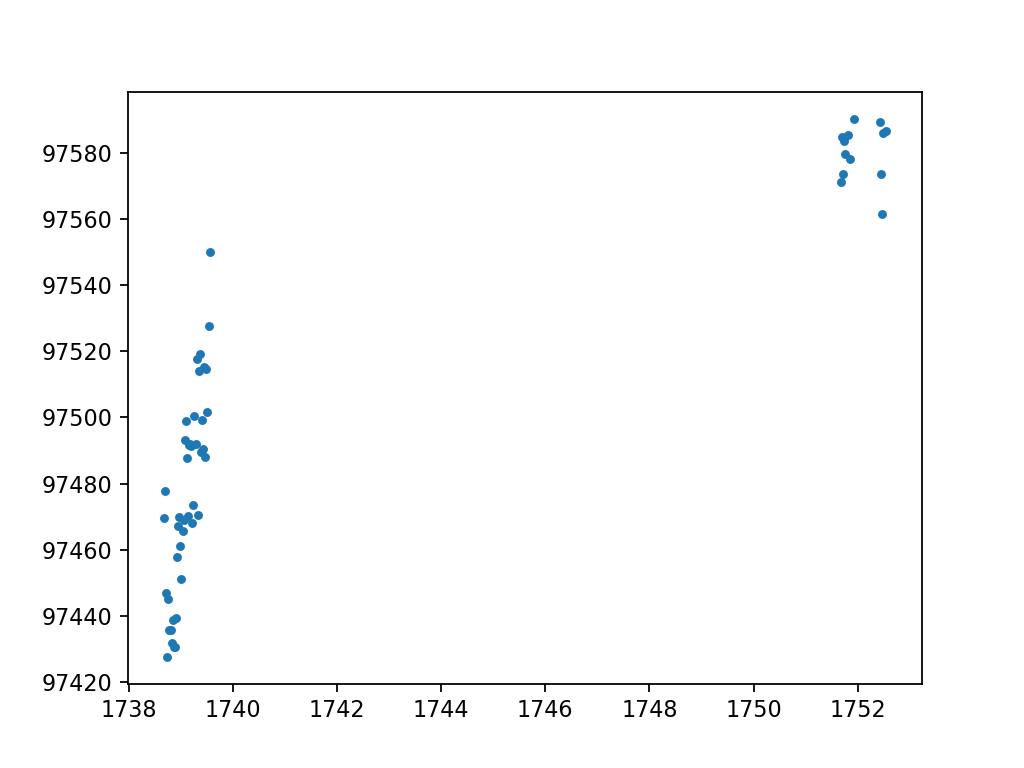

In [203]:
plt.figure()
plt.plot(tpf.time[ind],np.nansum(tpf.flux[ind],axis=(1,2)),'.')

In [99]:
Downsample(test).shape

(20, 20)

<IPython.core.display.Javascript object>


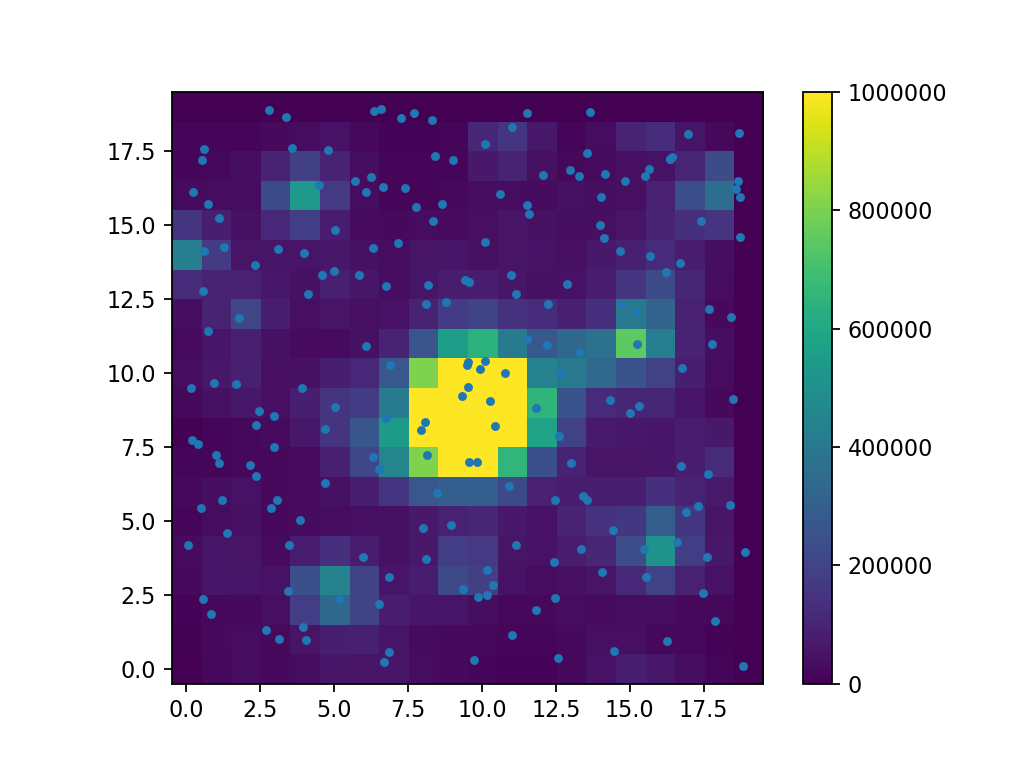

In [112]:
plt.figure()
plt.imshow(c,origin='lower',vmax=1000000)
plt.colorbar()
plt.plot(pos[:,0],pos[:,1],'.')

In [119]:
g = 22
i = 21.5

In [125]:
t = i - 0.00206*(g-i)**3 - 0.0237*(g-i)**2 + 0.00573*(g-i) - .3078

In [126]:
10**(-2/5*(t-20.44))

0.5017033489240423

In [122]:
ps_g_mag = g
ps_i_mag = i

In [123]:
syn_tess_mag = (- 0.00206*np.power(ps_g_mag-ps_i_mag, 3) 
                - 0.02370*np.power(ps_g_mag-ps_i_mag, 2) 
                + 0.00573*(ps_g_mag-ps_i_mag) 
                + ps_i_mag - 0.3078)
#And now the flux
syn_tess_cts = np.power(10, -(syn_tess_mag -20.44)/2.5)

In [124]:
syn_tess_cts

0.5017033489240423